## 모듈러티 벨류 동일 비중 포트폴리오
### 금리, 물가 상승 시기
각 클러스트 상위 10개씩 뽑아서 합침

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from capstone.util import load_kospi_data, load_dataset
import os
import warnings

from matplotlib import ticker
warnings.filterwarnings(action='ignore')
import networkx as nx
import community as community_louvain

### 모듈러티 network

In [9]:
from modularity.util import load_kospi_data, create_1st_dataset

pickle_path = '../pickle'
kospi_path = '../data/kospi200_stocks.xlsx'

interest_rate_increase = {
    "name" : 'interest_rate_increase',
    "start_date" : '2020-01-01',
    "end_date": '2022-03-01'
}

kospi_pickle_path = pickle_path + '/kospi_data.pickle'
kospi_data = load_kospi_data(kospi_pickle_path,kospi_path)
interest_rate_pickle_path = pickle_path + f'/{interest_rate_increase["name"]}.pickle'

df_interest_rate = load_dataset(kospi_data,interest_rate_pickle_path,interest_rate_increase['start_date'],interest_rate_increase['end_date'])

In [10]:
# interest_rate increase
test_df = df_interest_rate[:'2021-01-01']
validation_df = df_interest_rate['2021-01-02':]

In [11]:
from modularity.calculate_modularity import calculate_louvain
from community import community_louvain

partition,G = calculate_louvain(test_df,threshold=0.30)
modularity_value = community_louvain.modularity(partition,G)
print(f"MODULARITY : {modularity_value}")

MODULARITY : 0.2015448118363189


In [12]:
n_clusters = len(set(partition.values()))
print(f"클러스터 갯수 : {n_clusters}")

# 클러스터 개수만큼 딕셔너리 생성
dict_clusters = {i : [] for i in range(n_clusters)}

클러스터 갯수 : 3


In [13]:
# 클러스터 기준으로 군집 분류 
for stock_code,cluster in partition.items():
    dict_clusters[cluster].append(stock_code)

# 각 군집별로 데이터프레임 생성
clusters_list = []
for cluster in dict_clusters.keys():
    clusters_list.append(df_interest_rate[dict_clusters[cluster]])

# validation 각 군집별로 데이터프레임 생성
val_clusters_list = []
for cluster in dict_clusters.keys():
    val_clusters_list.append(validation_df[dict_clusters[cluster]])

In [14]:
# 엑셀 용량이 커서 미리 저장
def make_df_value(pickle_path:str, excel_path:str):
    if os.path.isfile(pickle_path):
        return pd.read_pickle(pickle_path)

    df = pd.read_excel(excel_path, sheet_name=0, header=None)
    data_value = df.iloc[12:].reset_index(drop=True) # 12번째 행부터 데이터프레임의 데이터를 가져오도록 설정
    data_value.drop(data_value.index[11], inplace=True)

    data_value.columns = df.iloc[8]  # 8번째 행을 컬럼명으로 설정
    data_value = data_value.rename(columns={data_value.columns[0]: 'date'})  # 첫 번째 컬럼 이름을 'date'로 변경
    data_value['date'] = pd.to_datetime(data_value['date'], errors='coerce')  # 날짜 형식 변환
    data_value = data_value.set_index(data_value.columns[0]) # 첫 번째 열을 인덱스로 설정하고 해당 열 제거
    data_value.index = pd.to_datetime(data_value.index, errors='coerce') # 인덱스를 datetime 형식으로 변환
    data_value.columns.name = 'Code'  # 종목 코드에 이름 설정
    data_value.index.name = 'Date'    # 날짜 인덱스에 이름 설정
    data_value.iloc[1, :] = np.nan
    data_value_drop = data_value.dropna(how='all')

    data_value_drop.to_pickle(pickle_path)

    return data_value_drop


In [15]:
data_value = make_df_value('../pickle/data_value','../data/kospi200_stocks_valuation.xlsx')

In [16]:
# PER(배), PBR(배) ESP(원) 컬럼들만 추출 
selected_columns = ['PER(배)', 'PBR(배)', 'EPS(원)']
value_columns = {}
for column in selected_columns:
    value_columns[f'{column}'] = data_value.iloc[0] == column

# 데이터 프레임 생성 
df_value_columns = {}
for key, value in value_columns.items():
    df_value_columns[key] = data_value.loc[:, value]
    df_value_columns[key].drop(df_value_columns[key].index[0], inplace=True)

df_value_1st_year = {}
start_date = '2020-01-01'
end_date = '2021-01-01'
for key, value in  df_value_columns.items():
    df_value_1st_year[key] = value.loc[start_date:end_date, :]

In [17]:
def filter_stocks(df_cluster,df_per,df_pbr,per_upper = 1,pbr_upper = 0):
    # df_per, df_pbr에 해당하는 공통 종목들만 필터링
    common_columns = df_cluster.columns.intersection(df_per.columns).intersection(df_pbr.columns)

    # 조건: per < 1 and pbr < 0에 해당하는 종목 필터링
    last_per = df_per[common_columns].iloc[-1]
    last_pbr = df_pbr[common_columns].iloc[-1]
    filtered_stocks = last_per[(last_per < per_upper) & (last_pbr < pbr_upper)].index.tolist()

    # 해당 조건을 만족하지 않는 종목을 df_cluster에서 제거 
    df_filtered = df_cluster.drop(columns=filtered_stocks, errors='ignore')
    return df_filtered

def rank_top_20(df_filtered_cluster, df_per, df_pbr):
    # PER 기준으로 랭킹 매기기 (오름차순)
    per_ranking = df_per.iloc[-1].rank(method='min').to_numpy()
    # PBR 기준으로 랭킹 매기기 (오름차순)
    pbr_ranking = df_pbr.iloc[-1].rank(method='min').to_numpy()

    # 두 랭킹 합산
    combined_ranking = per_ranking + pbr_ranking

    # 랭킹 기준 상위 20개 추출
    top_20_stocks = np.argsort(combined_ranking)[:20]
    return df_filtered_cluster.columns[top_20_stocks].tolist()

# PER과 PBR 값의 조건에 맞게 종목  필터링하는 함수
def process_cluster(df_cluster, df_per, df_pbr, per_upper = 1, pbr_upper = 0):


    # 필터링된 종목에 대해서만 PER과 PBR을 사용하여 랭킹을 계산
    df_filtered = filter_stocks(df_cluster,df_per,df_pbr,per_upper,pbr_upper)
    top_20 = rank_top_20(df_filtered, df_per[df_filtered.columns], df_pbr[df_filtered.columns])

    return top_20

In [18]:
top20_clusters = {}
for idx, cluster in enumerate(clusters_list):
    top20_clusters[idx] = process_cluster(cluster,df_value_1st_year['PER(배)'],df_value_1st_year['PBR(배)'])

In [19]:
def calculate_extended_cumulative_returns(kospi_data:pd.DataFrame, top20_cluster_stocks:list[str], start_date:str):
    df_top_20 = kospi_data[top20_cluster_stocks].loc[start_date:]

    returns = df_top_20.pct_change().mean(axis=1)

    cumulative_returns = (1 + returns).cumprod() - 1

    return cumulative_returns

In [20]:
extended_cumulative_returns_clusters = {}

for key, top20_cluster in top20_clusters.items():
    extended_cumulative_returns_clusters[key] = calculate_extended_cumulative_returns(kospi_data, top20_cluster, start_date='2021-01-02')

In [21]:
comparision_df = {}

for key, value in extended_cumulative_returns_clusters.items():
    comparision_df[f'Cluster {key} Cumulative Returns(Extended'] = value
merged_dict = comparision_df
comparison_df_extended = pd.DataFrame(merged_dict)

In [22]:
# 클러스터 별 상위 10개 종목을 뽑는 함수
def get_top_10_stocks_from_clusters(clusters_list:list, df_per, df_pbr):
    combined_stocks = []

    for cluster in clusters_list:
        df_filtered = filter_stocks(cluster, df_per, df_pbr)
        top_10 = rank_top_20(df_filtered, df_per[df_filtered.columns],df_pbr[df_filtered.columns])[:10]
        combined_stocks.extend(top_10)

    return combined_stocks

In [30]:
top_30_stocks = get_top_10_stocks_from_clusters(clusters_list,df_value_1st_year['PER(배)'],df_value_1st_year['PBR(배)'])

# 중복 제거 
top_30_stocks_unique = list(set(top_30_stocks))

df_value = df_interest_rate[top_30_stocks_unique]

In [31]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print(f"중복제거전 : {len(top_30_stocks)} \n중복제거후 : {len(top_30_stocks_unique)}")

중복제거전 : 30 
중복제거후 : 30


In [32]:
from capstone.portfolio_model import equal_weighting_portfolio

portfolio_daily_return,portfolio_cum_return = equal_weighting_portfolio(kospi_data, df_value, '2021-01-02','2022-03-01')

2021-01-02부터 2022-03-01 까지 동일 비중 투자 누적 수익률 : 30.07%


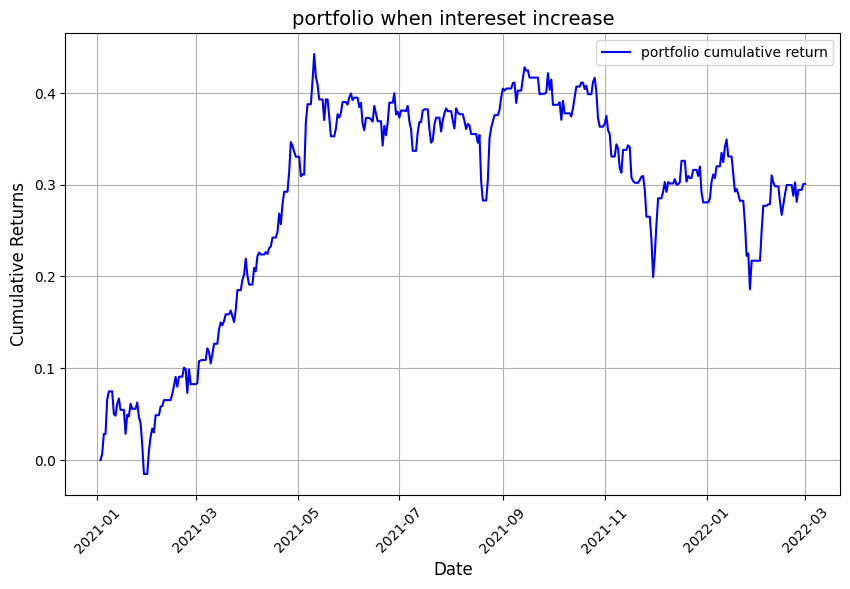

In [33]:
from capstone.display import plot_portfolio
increase_rate_info = {
    "title" : "portfolio when intereset increase",
    "start_date" : '2021-01-02',
    "end_date" : "2022-03-01",
    "save_url" : f"../fig/interest_increase/eq/value",
    "data_df" : portfolio_cum_return,
}

plot_portfolio(**increase_rate_info)

In [34]:
from capstone.evaluate_index import calculate_sharpe, calculate_sortino

샤프지수 = calculate_sharpe(portfolio_daily_return)
소프타노지수 = calculate_sortino(portfolio_daily_return)

print(f"샤프지수 : {샤프지수}")
print(f"소프타노 지수 : {소프타노지수}")


샤프지수 : 0.846974291993191
소프타노 지수 : 0.6840372246868671


In [38]:
kospi_cum_returns = pd.read_pickle("../pickle/202001_202203_CUM_KOSPI_200.pickle")

compare_with_kospi_info = {
    "title": "compare with benchmark when interest increase",
    "start_date" : '2021-01-02',
    "end_date" : "2022-03-01",
    "save_url" : "../fig/interest_increase/eq/value",
    "portfolio_df" : portfolio_cum_return,
    "kospi_df" : kospi_cum_returns

}

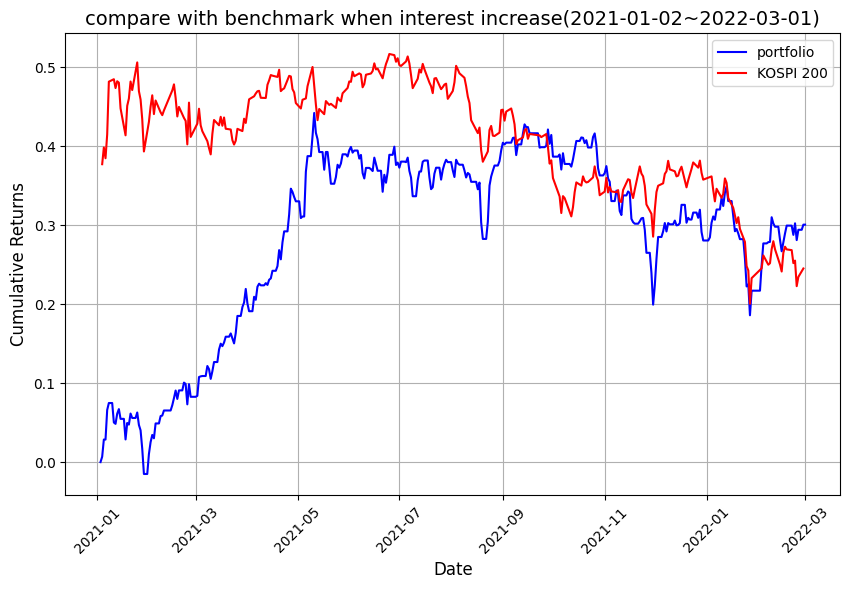

In [39]:
from capstone.display import compare_with_benchmark

compare_with_benchmark(**compare_with_kospi_info)

In [37]:
portfolio_cum_return[-1]

0.30068601332983125